In [1]:
import numpy as np 
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# EDA

In [2]:
train_df = pd.read_csv('train_sessions.csv')
test_df = pd.read_csv('test_sessions.csv')
train_df = train_df.sort_values(by='time1')

sites = ['site{}'.format(i) for i in range(1,11)]
times = ['time{}'.format(i) for i in range(1,11)]

train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')



In [5]:
y_train = train_df['target']

In [3]:
train_df.head()

,session_id,site1,time1,site2,time2,site3,time3,site4,time4,site5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
21668,21669,56,2013-01-12 08:05:57,55,2013-01-12 08:05:57,0,NaT,0,NaT,0,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
54842,54843,56,2013-01-12 08:37:23,55,2013-01-12 08:37:23,56,2013-01-12 09:07:07,55,2013-01-12 09:07:09,0,...,NaT,0,NaT,0,NaT,0,NaT,0,NaT,0
77291,77292,946,2013-01-12 08:50:13,946,2013-01-12 08:50:14,951,2013-01-12 08:50:15,946,2013-01-12 08:50:15,946,...,2013-01-12 08:50:16,948,2013-01-12 08:50:16,784,2013-01-12 08:50:16,949,2013-01-12 08:50:17,946,2013-01-12 08:50:17,0
114020,114021,945,2013-01-12 08:50:17,948,2013-01-12 08:50:17,949,2013-01-12 08:50:18,948,2013-01-12 08:50:18,945,...,2013-01-12 08:50:18,947,2013-01-12 08:50:19,945,2013-01-12 08:50:19,946,2013-01-12 08:50:19,946,2013-01-12 08:50:20,0
146669,146670,947,2013-01-12 08:50:20,950,2013-01-12 08:50:20,948,2013-01-12 08:50:20,947,2013-01-12 08:50:21,950,...,2013-01-12 08:50:21,946,2013-01-12 08:50:21,951,2013-01-12 08:50:22,946,2013-01-12 08:50:22,947,2013-01-12 08:50:22,0


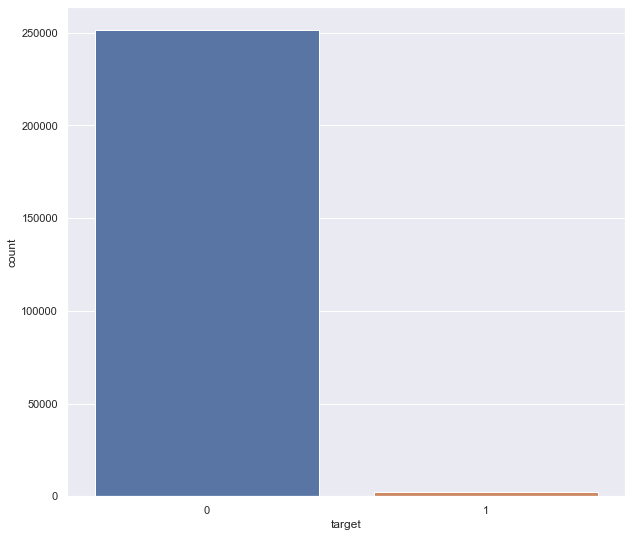

In [6]:
#Class Imbalance
plt.figure(figsize=(10,9))
sns.countplot(y_train)

In [7]:
import pickle
with open(r"site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

In [8]:
site_dict = pd.DataFrame(list(site_dict.keys()), index = list(site_dict.values()), columns = ['site'])

In [9]:
top_websites_of_alice = pd.Series(train_df[train_df.target==1][sites].values.flatten()).value_counts()\
                        .sort_values(ascending = False). head() 

In [10]:
top_websites_of_alice

77    1382
80    1354
76    1307
29     897
21     857
dtype: int64

In [11]:
time_df = pd.DataFrame(index = train_df.index)
time_df['target'] = train_df['target']
time_df['min'] = train_df[times].min(axis = 1)
time_df['max'] = train_df[times].max(axis = 1)
time_df['seconds'] = (time_df['max'] - time_df['min'])

In [12]:
time_df['seconds'] = time_df['seconds'] / np.timedelta64(1, 's')

In [13]:
time_df

,target,min,max,seconds
21668,0,2013-01-12 08:05:57,2013-01-12 08:05:57,0.0
54842,0,2013-01-12 08:37:23,2013-01-12 09:07:09,1786.0
77291,0,2013-01-12 08:50:13,2013-01-12 08:50:17,4.0
114020,0,2013-01-12 08:50:17,2013-01-12 08:50:20,3.0
146669,0,2013-01-12 08:50:20,2013-01-12 08:50:22,2.0
...,...,...,...,...
12223,0,2014-04-30 23:33:48,2014-04-30 23:34:00,12.0
164437,0,2014-04-30 23:34:15,2014-04-30 23:37:13,178.0
12220,0,2014-04-30 23:38:08,2014-04-30 23:38:36,28.0
156967,0,2014-04-30 23:38:36,2014-04-30 23:39:53,77.0


# Initial Base Model

In [83]:
train_df = pd.read_csv('train_sessions.csv')
test_df = pd.read_csv('test_sessions.csv')
train_df = train_df.sort_values(by='time1')
sites = ['site{}'.format(i) for i in range(1,11)]
times = ['time{}'.format(i) for i in range(1,11)]
train_df[times] = train_df[times].apply(pd.to_datetime)
test_df[times] = test_df[times].apply(pd.to_datetime)
train_df[sites].fillna(0).astype('int').to_csv('train_session_test.txt',sep = ' ', index = None,header = None)
test_df[sites].fillna(0).astype('int').to_csv('test_session_test.txt',sep = ' ', index = None, header = None)

In [4]:
def write_to_submission(predicted_labels, out_file,
                        target = 'target', index_label= 'session_id'):
    predicted_df = pd.DataFrame(predicted_labels,
                               index = np.arange(1, predicted_labels.shape[0] + 1),
                               columns = [target])
    predicted_df.to_csv(out_file, index_label= index_label)

In [84]:
%%time
cv = CountVectorizer()

with open('train_session_test.txt') as inp_train_file:
    X_train = cv.fit_transform(inp_train_file)

with open('test_session_test.txt') as inp_test_file:
    X_test = cv.transform(inp_test_file)

Wall time: 3.02 s


In [43]:
X_train.shape, X_test.shape

((253561, 41592), (82797, 41592))

In [85]:
y_train = train_df['target']

# Base Model (90.8%)
Logistic Classification
Features - Sites1-10

In [57]:
logit = LogisticRegression(C = 1, random_state = 17, max_iter = 400)

In [58]:
%%time
cv_scores = cross_val_score(logit, X_train, y_train, cv = 5, scoring = 'roc_auc')

Wall time: 34.5 s


In [60]:
np.mean(cv_scores)

0.8851930327723323

In [61]:
%%time
logit.fit(X_train, y_train)

Wall time: 8.74 s


LogisticRegression(C=1, max_iter=400, random_state=17)

In [50]:
y_test = logit.predict_proba(X_test)[:, 1]

In [51]:
y_test

array([2.29619743e-03, 3.44038689e-09, 1.11953739e-08, ...,
       8.71023816e-03, 4.32067924e-04, 1.86124519e-05])

In [62]:
# CV 96.27
write_to_submission(y_test, 'submission1.txt') ## .908

In [22]:
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

In [25]:
train_df.drop(['target'], inplace = True, axis = 1)

In [29]:
time_split = TimeSeriesSplit(n_splits = 10)

In [66]:
%%time
logit = LogisticRegression(C = 1, random_state = 17, max_iter = 200)
cv_scores = cross_val_score(logit, X_train, y_train, cv = time_split, scoring = 'roc_auc')

c:\python\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
c:\python\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_L

Wall time: 37.2 s


c:\python\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [76]:
cv_scores.mean()

0.8645084157002805

# Model 2 with Time of Day feature

In [78]:
train_df[sites] = train_df[sites].fillna(0).astype('int')
test_df[sites] = test_df[sites].fillna(0).astype('int')

In [80]:
def add_time_features(df, X_sparse):
    hour = df['time1'].apply(lambda ts: ts.hour)
    morning = ((hour >= 7) & (hour <= 11)).astype('int')
    day = ((hour >= 12) & (hour <= 18)).astype('int')
    evening = ((hour >= 19) & (hour <= 23)).astype('int')
    night = ((hour >= 0) & (hour <= 6)).astype('int')
    X = hstack([X_sparse, morning.values.reshape(-1, 1), 
                day.values.reshape(-1, 1), evening.values.reshape(-1, 1), 
                night.values.reshape(-1, 1)])
    return X

In [86]:
%%time
X_train_new = add_time_features(train_df.fillna(0), X_train)
X_test_new = add_time_features(test_df.fillna(0), X_test)

Wall time: 1min 24s


In [87]:
%%time
cv_scores = cross_val_score(logit, X_train_new, y_train, cv=time_split,scoring='roc_auc', n_jobs=-1) # hangs with n_jobs > 1, and locally this runs much faster

Wall time: 16.2 s


In [88]:
logit.fit(X_train_new, y_train)


c:\python\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1, max_iter=200, random_state=17)

In [91]:
logit_test_pred2 = logit.predict_proba(X_test_new)[:, 1]
write_to_submission(logit_test_pred2, 'subm2.csv') #93.580

# Weekend Indicator Feature

In [115]:
def add_weekend_features(df, X_sparse= None):
    day = df['time1'].apply(lambda ts: ts.weekday())
    weekend = ((day == 6) | ((day == 5))).astype('int')
    X = hstack([X_sparse,weekend.values.reshape(-1, 1)])
    return X

In [117]:
%%time
X_train_new2 = add_weekend_features(train_df.fillna(0), X_train_new)
X_test_new2 = add_weekend_features(test_df.fillna(0), X_test_new)

Wall time: 1min 28s


In [118]:
%%time
cv_scores = cross_val_score(logit, X_train_new2, y_train, cv=time_split,scoring='roc_auc', n_jobs=-1) # hangs with n_jobs > 1, and locally this runs much faster

Wall time: 19.9 s


In [119]:
cv_scores.mean()

0.9102828359816

In [98]:
logit.fit(X_train_new2, y_train)
logit_test_pred3 = logit.predict_proba(X_test_new2)[:, 1]
write_to_submission(logit_test_pred3, 'subm3.csv') #93.611

c:\python\lib\site-packages\sklearn\linear_model\_logistic.py:764: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [120]:
c_values = np.logspace(-2, 2, 10)

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=-1, cv=time_split, verbose=1)


In [121]:
%%time
logit_grid_searcher.fit(X_train_new2, y_train) 

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.4min finished


Wall time: 1min 29s


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             estimator=LogisticRegression(C=1, max_iter=200, random_state=17),
             n_jobs=-1,
             param_grid={'C': array([1.00000000e-02, 2.78255940e-02, 7.74263683e-02, 2.15443469e-01,
       5.99484250e-01, 1.66810054e+00, 4.64158883e+00, 1.29154967e+01,
       3.59381366e+01, 1.00000000e+02])},
             scoring='roc_auc', verbose=1)

In [122]:
logit_grid_searcher.best_score_, logit_grid_searcher.best_params_


(0.9115929020417856, {'C': 0.21544346900318834})

In [106]:
logit_test_pred4 = logit_grid_searcher.predict_proba(X_test_new2)[:, 1]
write_to_submission(logit_test_pred4, 'subm4.csv') # 0.9404

# Random Forest

In [111]:
param_grid = {'max_depth' : [3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24],
             'n_estimators' : [5, 10, 15, 20, 30, 50, 75, 100]}
rf = RandomForestClassifier()
rf_searcher = GridSearchCV(estimator=rf, param_grid = param_grid,
                                  scoring='roc_auc', n_jobs=-1, cv=time_split, verbose=1)
rf_searcher.fit(X_train_new2, y_train)

Fitting 10 folds for each of 88 candidates, totalling 880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.5s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed: 22.4min
[Parallel(n_jobs=-1)]: Done 880 out of 880 | elapsed: 29.9min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 9, 11, 13, 15, 17, 20, 22, 24],
                         'n_estimators': [5, 10, 15, 20, 30, 50, 75, 100]},
             scoring='roc_auc', verbose=1)

In [112]:
rf_searcher.best_score_, rf_searcher.best_params_

(0.9047862783306154, {'max_depth': 20, 'n_estimators': 50})

In [113]:
rf_test_pred5 = rf_searcher.predict_proba(X_test_new2)[:, 1]
write_to_submission(rf_test_pred5, 'subm5.csv') # 0.